Muhammad Faris Muzakki - Sr. Data Engineer Test

## Data Ingestion

### Open Connection to Source Data

In [141]:
import pandas as pd
import os
import re
from datetime import datetime
from urllib.parse import quote_plus
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta


In [81]:
# in Real development, these information should be stored into secrect or .env
USER = 'admin'
PASSWORD = 'admin'
DATABASE = 'bobobox'
HOST = 'localhost'
API = 'API'
PORT = 5432

In [82]:
uri = f"postgresql+psycopg2://{quote_plus(USER)}:\{quote_plus(PASSWORD)}@{HOST}:{PORT}/{DATABASE}"
alchemyEngine = create_engine(uri)
dbConnection = alchemyEngine.raw_connection()

In [83]:
current_date = str(datetime.now().date()).replace('-', '')
current_date

'20240825'

### source to raw

In [84]:
def get_sql_queries(base_folder):
    sql_queries = {}

    # Walk through all directories and subdirectories
    for root, _, files in os.walk(base_folder):
        for file in files:
            if file.endswith(".sql"):
                file_path = os.path.join(root, file)
                
                # Read the SQL query from the file
                with open(file_path, 'r') as f:
                    query = f.read()
                
                # Store the query in the dictionary with the relative file path as the key
                relative_path = os.path.relpath(file_path, base_folder)
                sql_queries[relative_path] = query

    return sql_queries

In [85]:
base_folder = 'queries'
queries = get_sql_queries(base_folder)

In [86]:
for directory, query in queries.items():

    # define raw location
    directory = directory.split('/')
    schema = directory[1]
    filename = directory[2].split('.')[1]
    raw_directory = f'datawarehouse/raw/{schema}/{filename}/{current_date}/'

    # execute data ingestion query
    data = pd.read_sql(query, dbConnection)

    # store data into raw
    if not os.path.exists(raw_directory): # create folder if doesnt exist
        os.makedirs(raw_directory)

    data.to_csv(raw_directory + f'{filename}.csv', index=False)

/var/folders/sq/_27zqsss0s304lxljksdbb4r0000gn/T/ipykernel_71688/3464775025.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, dbConnection)


In [87]:
# sample of raw data
data.head()

,id,reservation_id,check_in_date,check_out_date,room_type,total_room_price,total_discount
0,1,2,2024-08-26,2024-08-28,Double,291.45,18.88
1,2,3,2024-08-27,2024-08-29,Double,179.74,14.38
2,3,4,2024-08-28,2024-08-30,Double,467.62,26.38
3,4,5,2024-08-29,2024-08-31,Double,64.20,11.62
4,5,6,2024-08-30,2024-09-01,Single,454.32,46.45


## Data Cleansing

In [88]:
def normalize_data(value):
    try:
        if isinstance(value, bytes):
            value = value.decode('utf-8')
        
        if isinstance(value, str):
            value = value.lower()
            value = re.sub(r'[ _-]+', '-', value)
    except Exception as e:
        print(f"Error processing value: {value} ({type(value)}) - {e}")

    return value

### raw to staging

In [89]:
# Loop untuk data ingestion dari raw data
for directory, query in queries.items():

    # Define raw and staging locations
    directory = directory.split('/')
    schema = directory[1]
    filename = directory[2].split('.')[1]
    
    raw_directory = f'datawarehouse/raw/{schema}/{filename}/{current_date}/'
    staging_directory = f'datawarehouse/staging/{schema}/{filename}/{current_date}/'
    
    # load raw data
    csv_file_path = os.path.join(raw_directory, f'{filename}.csv')
    data = pd.read_csv(csv_file_path)
    
    # data cleaning
    data.columns = data.columns.str.lower()  # lower all column name
    data = data.apply(lambda col: col.map(normalize_data) if col.dtype == 'object' else col)  # normalize data

    if not os.path.exists(staging_directory):
        os.makedirs(staging_directory)
    
    staging_file_path = os.path.join(staging_directory, f'{filename}.csv')
    data.to_csv(staging_file_path, index=False)

In [90]:
# sample of staging data
data.head()

,id,reservation_id,check_in_date,check_out_date,room_type,total_room_price,total_discount
0,1,2,2024-08-26,2024-08-28,double,291.45,18.88
1,2,3,2024-08-27,2024-08-29,double,179.74,14.38
2,3,4,2024-08-28,2024-08-30,double,467.62,26.38
3,4,5,2024-08-29,2024-08-31,double,64.20,11.62
4,5,6,2024-08-30,2024-09-01,single,454.32,46.45


## Data Transformation

asumption the staging was stored into columnar db, so we can transform the data from query

In [91]:
datamart_directory = f'datawarehouse/datamart/{schema}/{filename}/{current_date}/'

### Marketing - Promotion & Reservation Information

In [92]:
query = \
"""
WITH staging AS (
    SELECT
        r.id AS reservation_id,
        r.hotel_id,
        r.voucher_code,
        r.total_room_price,
        r.total_discount,
        v.campaign_id
    FROM
        reservation.reservations r
    LEFT JOIN
        promotion.voucher v ON r.voucher_code = v.code
    WHERE
        v.campaign_id IS NOT NULL -- Filter untuk memastikan hanya voucher dengan campaign_id yang valid
),
final AS (
    SELECT
        c.id AS campaign_id,
        c.name AS campaign_name,
        COUNT(sr.reservation_id) AS total_reservations,
        COALESCE(SUM(sr.total_room_price), 0) AS total_room_revenue,
        COALESCE(SUM(sr.total_discount), 0) AS total_discount_given
    FROM
        promotion.campaign c
    LEFT JOIN
        staging sr ON sr.campaign_id = c.id
    GROUP BY
        c.id, c.name
)
SELECT * FROM final;
"""

data = pd.read_sql(query, dbConnection)
data

/var/folders/sq/_27zqsss0s304lxljksdbb4r0000gn/T/ipykernel_71688/1048135255.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, dbConnection)


,campaign_id,campaign_name,total_reservations,total_room_revenue,total_discount_given
0,55,Campaign 55,10,5505.04,559.35
1,27,Campaign 27,10,5999.55,356.40
2,23,Campaign 23,10,6839.43,483.69
3,56,Campaign 56,10,7435.32,450.43
4,91,Campaign 91,10,6097.91,312.20
...,...,...,...,...,...
95,1,Campaign 1,10,7370.40,393.66
96,76,Campaign 76,10,3820.16,572.61
97,5,Campaign 5,10,5589.47,374.05
98,18,Campaign 18,10,5503.39,633.64


In [93]:
if not os.path.exists(datamart_directory):
    os.makedirs(datamart_directory)

# asumtion the datamart loaded into columnar db not to file like this.
data.to_csv(f'{datamart_directory}/promotion_and_reservation.csv', index=False)

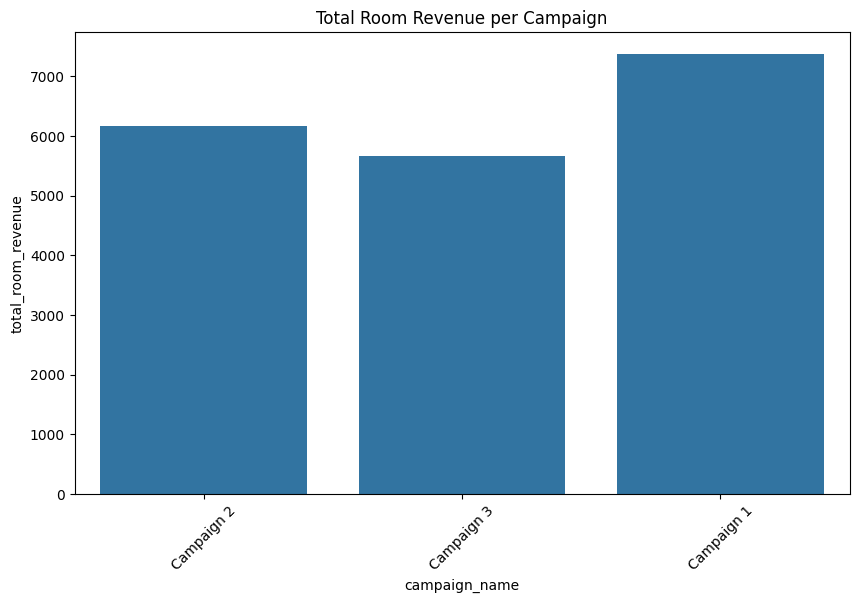

In [94]:
# sampling data
data = data[
    (data['campaign_id'].isin([1, 2, 3]))
]

plt.figure(figsize=(10, 6))
sns.barplot(x='campaign_name', y='total_room_revenue', data=data)
plt.title('Total Room Revenue per Campaign')
plt.xticks(rotation=45)
plt.show()

### Finance - Payment Reservation

In [109]:
query = \
"""
WITH staging AS (
    SELECT
        r.id AS reservation_id,
        r.hotel_id,
        r.total_room_price,
        r.total_discount,
        p.amount AS payment_amount,
        pm.third_party_id,
        p.created_datetime AS payment_date
    FROM
        reservation.reservations r
    LEFT JOIN
        payment.payments p ON r.id = p.payment_method_id
    LEFT JOIN
        payment.paymentmethods pm ON p.payment_method_id = pm.id
),
final AS (
    SELECT
        h.id AS hotel_id,
        h.name AS hotel_name,
        COUNT(sr.reservation_id) AS total_reservations,
        SUM(sr.total_room_price) AS total_room_revenue,
        SUM(sr.total_discount) AS total_discount_given,
        SUM(sr.payment_amount) AS total_payment_received,
        TO_CHAR(sr.payment_date, 'YYYY-MM') AS payment_month_year,
        ptp.name AS third_party_name
    FROM
        reservation.hotels h
    LEFT JOIN
        staging sr ON sr.hotel_id = h.id
    LEFT JOIN
        payment.paymentthirdparties ptp ON sr.third_party_id = ptp.id
    GROUP BY
        h.id, h.name, TO_CHAR(sr.payment_date, 'YYYY-MM'), ptp.name
)
SELECT * FROM final;
"""

data = pd.read_sql(query, dbConnection)
data

/var/folders/sq/_27zqsss0s304lxljksdbb4r0000gn/T/ipykernel_71688/497763687.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, dbConnection)


,hotel_id,hotel_name,total_reservations,total_room_revenue,total_discount_given,total_payment_received,payment_month_year,third_party_name
0,3,Hotel 3,1,118.85,29.90,307.46,2025-06,Third Party 3
1,21,Hotel 21,1,308.10,61.75,202.12,2024-12,Third Party 1
2,22,Hotel 22,1,921.86,62.44,224.79,2024-09,Third Party 2
3,39,Hotel 39,1,882.79,95.71,87.23,2027-01,Third Party 9
4,38,Hotel 38,1,212.15,29.28,500.48,2025-12,Third Party 8
...,...,...,...,...,...,...,...,...
1045,11,Hotel 11,1,415.39,44.31,28.43,2024-10,Third Party 1
1046,44,Hotel 44,1,1095.46,28.96,166.51,2026-09,Third Party 4
1047,14,Hotel 14,1,144.08,62.65,446.45,2025-05,Third Party 4
1048,13,Hotel 13,1,348.57,13.97,325.49,2027-01,Third Party 3


In [110]:
if not os.path.exists(datamart_directory):
    os.makedirs(datamart_directory)

# asumtion the datamart loaded into columnar db not to file like this.
data.to_csv(f'{datamart_directory}/payment_reservation.csv', index=False)

/var/folders/sq/_27zqsss0s304lxljksdbb4r0000gn/T/ipykernel_71688/291163443.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['payment_month_year'] = pd.to_datetime(data['payment_month_year'], format='%Y-%m')


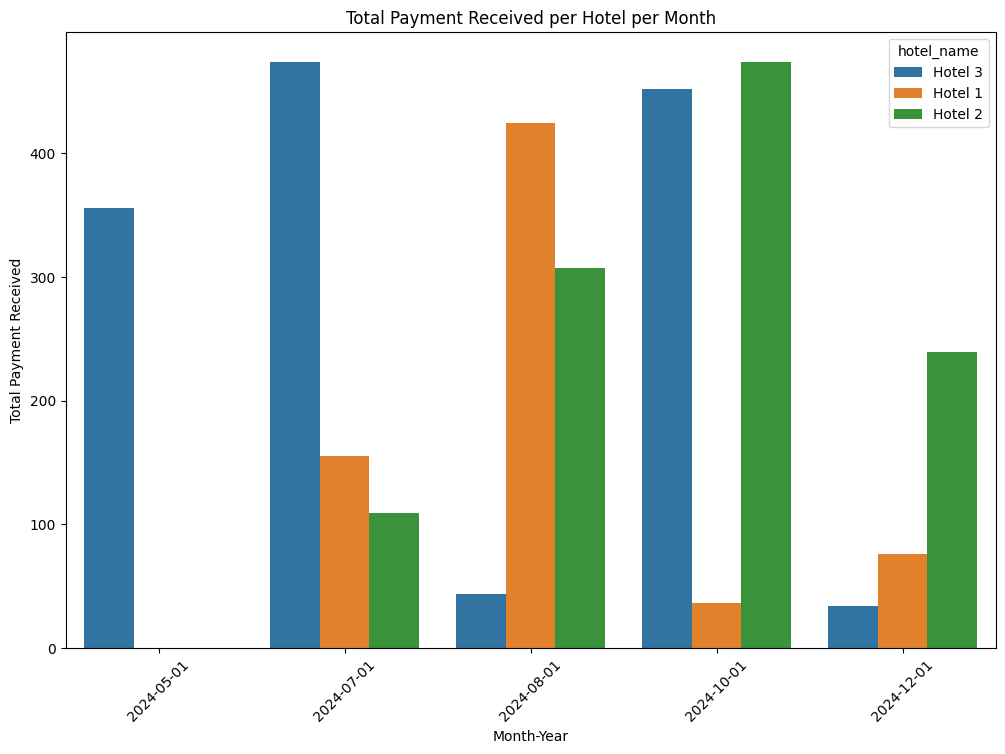

In [116]:
# sampling data
data = data[
    (data['hotel_name'].isin(['Hotel 1', 'Hotel 2', 'Hotel 3'])) &
    (data['payment_month_year'].str.contains('2024'))
]

# Convert payment_month_year to datetime
data['payment_month_year'] = pd.to_datetime(data['payment_month_year'], format='%Y-%m')
# Sort data by payment_month_year
data = data.sort_values('payment_month_year')

# Set up the plot
plt.figure(figsize=(12, 8))

# Barplot for total payment received per hotel per month
sns.barplot(x='payment_month_year', y='total_payment_received', hue='hotel_name', data=data)

# Adding title and labels
plt.title('Total Payment Received per Hotel per Month')
plt.xlabel('Month-Year')
plt.ylabel('Total Payment Received')

# Rotating x-ticks for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Branch Hotel - Guest Stays

In [158]:
query = \
"""
WITH staging_stays AS (
    SELECT
        s.id AS stay_id,
        s.date AS stay_date,
        r.name AS room_name,
        r.room_type,
        h.name AS hotel_name,
        su.name AS guest_name,
        su.email AS guest_email,
        su.phone_number AS guest_phone
    FROM
        stay.stays s
    LEFT JOIN
        stay.rooms r ON s.room_id = r.id
    LEFT JOIN
        stay.hotels h ON r.hotel_id = h.id
    LEFT JOIN
        stay.users su ON s.guest_id = su.id
),
final_stay_information AS (
    SELECT
        ss.stay_date,
        ss.hotel_name,
        ss.room_name,
        ss.room_type,
        ss.guest_name,
        ss.guest_email,
        ss.guest_phone
    FROM
        staging_stays ss
)
SELECT * FROM final_stay_information;
"""

data = pd.read_sql(query, dbConnection)
data

/var/folders/sq/_27zqsss0s304lxljksdbb4r0000gn/T/ipykernel_71688/3194116108.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, dbConnection)


,stay_date,hotel_name,room_name,room_type,guest_name,guest_email,guest_phone
0,2024-08-24,Hotel 3,Room 2,Double,User 2,user2@example.com,+1-800-555-0002
1,2024-08-23,Hotel 4,Room 3,Single,User 3,user3@example.com,+1-800-555-0003
2,2024-08-22,Hotel 5,Room 4,Double,User 4,user4@example.com,+1-800-555-0004
3,2024-08-21,Hotel 6,Room 5,Double,User 5,user5@example.com,+1-800-555-0005
4,2024-08-20,Hotel 7,Room 6,Single,User 6,user6@example.com,+1-800-555-0006
...,...,...,...,...,...,...,...
995,2023-12-03,Hotel 48,Room 497,Double,User 997,user997@example.com,+1-800-555-0997
996,2023-12-02,Hotel 49,Room 498,Single,User 998,user998@example.com,+1-800-555-0998
997,2023-12-01,Hotel 50,Room 499,Double,User 999,user999@example.com,+1-800-555-0999
998,2023-11-30,Hotel 1,Room 500,Double,User 1000,user1000@example.com,+1-800-555-1000


In [136]:
if not os.path.exists(datamart_directory):
    os.makedirs(datamart_directory)

# asumtion the datamart loaded into columnar db not to file like this.
data.to_csv(f'{datamart_directory}/promotion_and_reservation.csv', index=False)

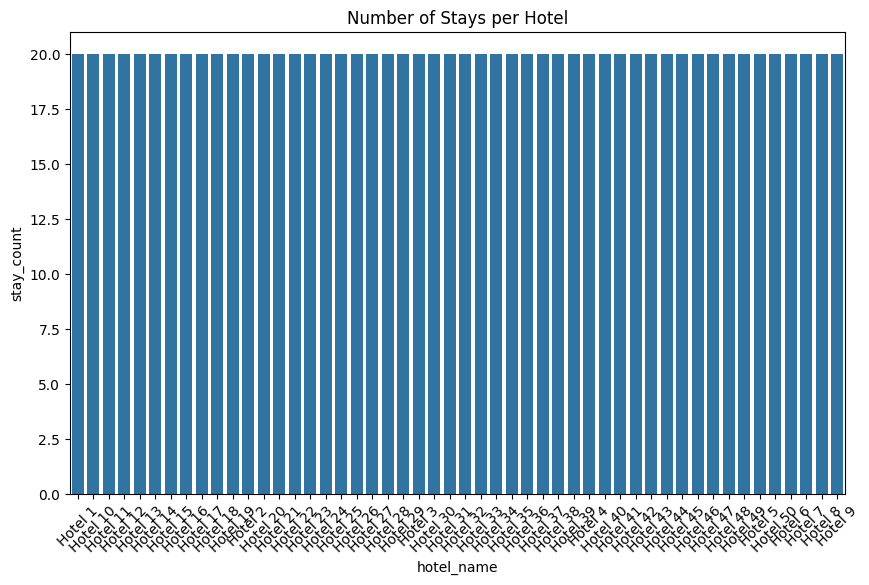

In [159]:
# sampling data
data = data[
    # (data['hotel_name'].isin(['Hotel 3', 'User 3', 'User 4']))
    data['stay_date'] >= datetime.now().date() - relativedelta(years=1)
]

stay_count = data.groupby('hotel_name').size().reset_index(name='stay_count')

plt.figure(figsize=(10, 6))
sns.barplot(x='hotel_name', y='stay_count', data=stay_count)
plt.title('Number of Stays per Hotel')
plt.xticks(rotation=45)
plt.show()